In [133]:
# Import needed libraries
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

# from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression

%load_ext autoreload
%autoreload 2
from outlier_generation_techniques import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare Data

In [2]:
# Download the dataset from kaggle (if needed)
import os 
need_download: bool = not os.path.exists("bank-note-authentication/BankNote_Authentication.csv")

if need_download:
    !kaggle datasets download ritesaluja/bank-note-authentication-uci-data
    !unzip bank-note-authentication-uci-data.zip -d bank-note-authentication

In [160]:
# Import the DIABETES data into a pandas frame
raw_df = pd.read_csv("bank-note-authentication/BankNote_Authentication.csv")
# raw_df = pd.read_csv("diabetes/diabetes.csv")
# raw_df = pd.read_csv("haberman/haberman.csv")

# Process by 
# 1. replacing "?" with Na
# 2. renaming the last column to "label"
processed_df = raw_df.copy()
processed_df.replace("?", pd.NA, inplace=True)
processed_df.rename(columns={processed_df.columns[-1]: "label"}, inplace=True)

# Filter out incomplete rows
complete_df = processed_df.dropna()
print(f"# complete entries = {len(complete_df)}, # incomplete entries = {len(raw_df) - len(complete_df)}")

# Split
X = complete_df.iloc[:, :-1]
y = complete_df.iloc[:, -1]

# Print class proportions
print(y.value_counts())

# complete entries = 1372, # incomplete entries = 0
label
0    762
1    610
Name: count, dtype: int64


# Generate outliers

In [ ]:
# # Generate 50 outliers for each class using the infeasExam method
# n_art_0 = 20
# n_art_1 = 20

# alpha = 2.0     # scaled based on feature scales
# epsilon = 2.0   # scaled based on feature scales

# # Function works with numpy arrays, not pandas dataframes
# X_art_0 = infeasExam(X[y==0].to_numpy(), n_art = n_art_0, alpha = alpha, epsilon = epsilon)
# X_art_1 = infeasExam(X[y==1].to_numpy(), n_art = n_art_1, alpha = alpha, epsilon = epsilon)

# # Add the outliers the pandas dataframe
# outlier_rows_0 = pd.DataFrame(X_art_0, columns = complete_df.columns[:-1])
# outlier_rows_0["label"] = 0
# outlier_rows_0["artificial"] = 1

# outlier_rows_1 = pd.DataFrame(X_art_1, columns = complete_df.columns[:-1])
# outlier_rows_1["label"] = 1
# outlier_rows_1["artificial"] = 1

# complete_df_with_outliers = complete_df.copy()
# complete_df_with_outliers["artificial"] = 0

# complete_df_with_outliers = pd.concat([complete_df_with_outliers, outlier_rows_0, outlier_rows_1], ignore_index=True)


# Generate without respect to label, with random labels
n_art = int(len(X) * 0.05)
print(f"n_art = {n_art}")

# X_art = unifBox(X.to_numpy(), n_art, factor=5)
# X_art = gaussTail(X.to_numpy(), n_art)
# X_art = marginSample(X.to_numpy(), n_art)
# X_art = customGaussTail(X.to_numpy(), n_art, M = 0)       # changing M doesn't really change performance much...

X_art = infeasExam(X.to_numpy(), n_art, alpha = 5, epsilon = 20)
# y_art = np.random.randint(2, size=n_art)
y_art = 0

outlier_rows = pd.DataFrame(X_art, columns = complete_df.columns[:-1])
outlier_rows["label"] = y_art
outlier_rows["artificial"] = 1

# Concatenate outliers to original dataframe
complete_df_with_outliers = complete_df.copy()
complete_df_with_outliers["artificial"] = 0

complete_df_with_outliers = pd.concat([complete_df_with_outliers, outlier_rows], ignore_index=True)

X_with_outliers = complete_df_with_outliers.drop(columns={"label", "artificial"})
y_with_outliers = complete_df_with_outliers["label"]


n_art = 68


# Test logistic regression fit on original data

In [175]:
clf = LogisticRegression(random_state=0, max_iter = 1000).fit(X, y)
print(f"Logistic regression score = {clf.score(X, y)}")

Logistic regression score = 0.9897959183673469


In [176]:
clf_with_outliers = clf = LogisticRegression(random_state=0, max_iter = 1000).fit(X_with_outliers, y_with_outliers)
print(f"Logistic regression score with outliers = {clf_with_outliers.score(X_with_outliers, y_with_outliers)}")

Logistic regression score with outliers = 0.9513888888888888


# Plot functions

In [158]:
from itertools import combinations

def plot_pairwise_features(df):
    """
    Plots pairwise combinations of features from a DataFrame.

    Parameters:
        df: A DataFrame of features, including binary columns "label" and "artificial"

    Returns:
        fig (matplotlib.figure.Figure): The figure containing the subplots.
    """    
    fill_colors = {0: 'blue', 1: 'orange'}       # determines the fill colors based on class
    edge_colors = {0: 'black', 1: 'red'}         # determines the edge colors based on artificial (1 = artificial)

    labels = {0: 'Class 0', 1: 'Class 1'}

    # Get all unique pairs of column indices
    feature_columns = complete_df_with_outliers.columns.drop(["label", "artificial"])
    feature_pairs = list(combinations(feature_columns, 2))

    # Create a 2 x ceil(k/2) grid for the subplots
    fig, axes = plt.subplots(2, math.ceil(len(feature_pairs) / 2), figsize=(15, 10))
    fig.suptitle("Pairwise Feature Plots", fontsize=16)
    
    # Plot each pair on a subplot
    for ax, (feat1, feat2) in zip(axes.flatten(), feature_pairs):
        ax.set_xlabel(feat1)
        ax.set_ylabel(feat2)
        ax.set_title(f"{feat1} vs {feat2}")
        
        for label in [0, 1]:
            for artificial in [0, 1]:
                mask = (df["label"] == label) & (df["artificial"] == artificial)
                masked_df = df.loc[mask]

                # print(masked_df)

                ax.scatter(masked_df[feat1], masked_df[feat2], alpha=0.7, color=fill_colors[label], edgecolor=edge_colors[artificial])
        
    # Adjust layout for better spacing
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # rect adjusts space for the main title

    # Add a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=fill_colors[label], markersize=8, label=labels[label])
               for label in labels]
    fig.legend(handles=handles, loc='lower right', title="Classes", bbox_to_anchor=(1.0, 0.9))

    return fig

In [167]:
# Return a figure with two classes in 2D PCA
def plot_2D_PCA(df):
    fill_colors = {0: 'blue', 1: 'orange'}       # determines the fill colors based on class
    edge_colors = {0: 'black', 1: 'red'}         # determines the edge colors based on artificial (1 = artificial)

    labels = {0: 'Class 0', 1: 'Class 1'}
    
    # Project onto 2D using PCA
    pca = PCA(n_components = 2)
    X_pca = pca.fit_transform(df.drop(columns=["label", "artificial"]))

    # Convert the PCA result to a DataFrame for easy plotting
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df["label"] = df["label"]
    pca_df["artificial"] = df["artificial"]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 7))

    for label in [0, 1]:
        for artificial in [0, 1]:
            mask = (pca_df["label"] == label) & (pca_df["artificial"] == artificial)
            masked_pca_df = pca_df.loc[mask]

            ax.scatter(masked_pca_df["PC1"], masked_pca_df["PC2"], alpha=0.7, color=fill_colors[label], edgecolor=edge_colors[artificial])

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('PCA of Feature Data')

    # Add a legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=fill_colors[label], markersize=8, label=labels[label])
               for label in labels]
    fig.legend(handles=handles, loc='lower right', title="Classes", bbox_to_anchor=(1.0, 0.9))


    return fig

# Plot the data and the generated outliers

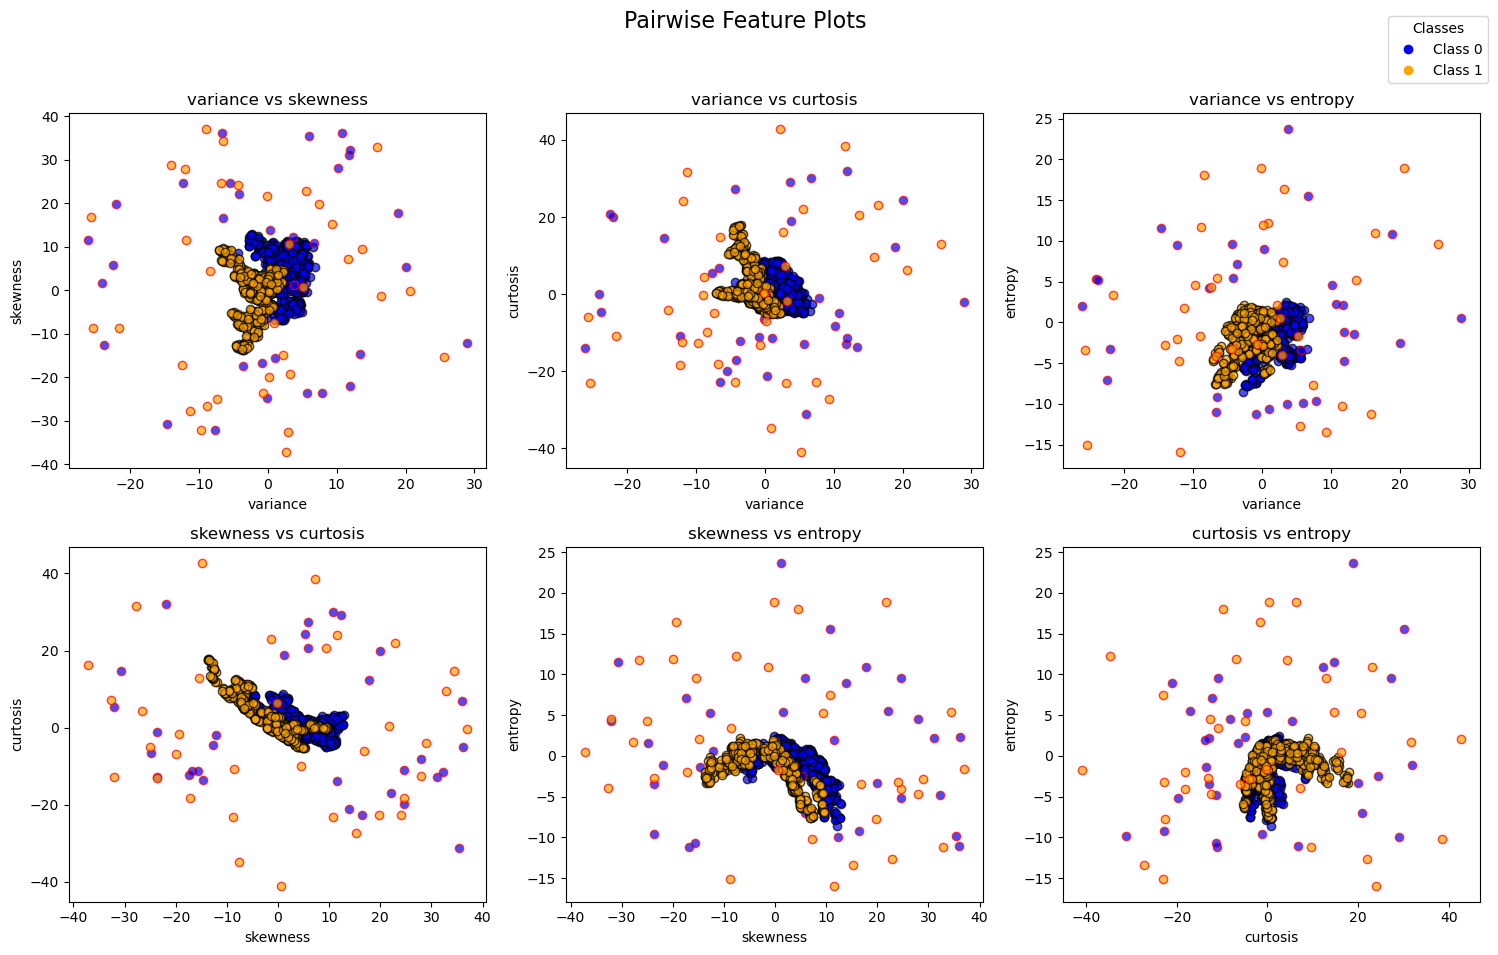

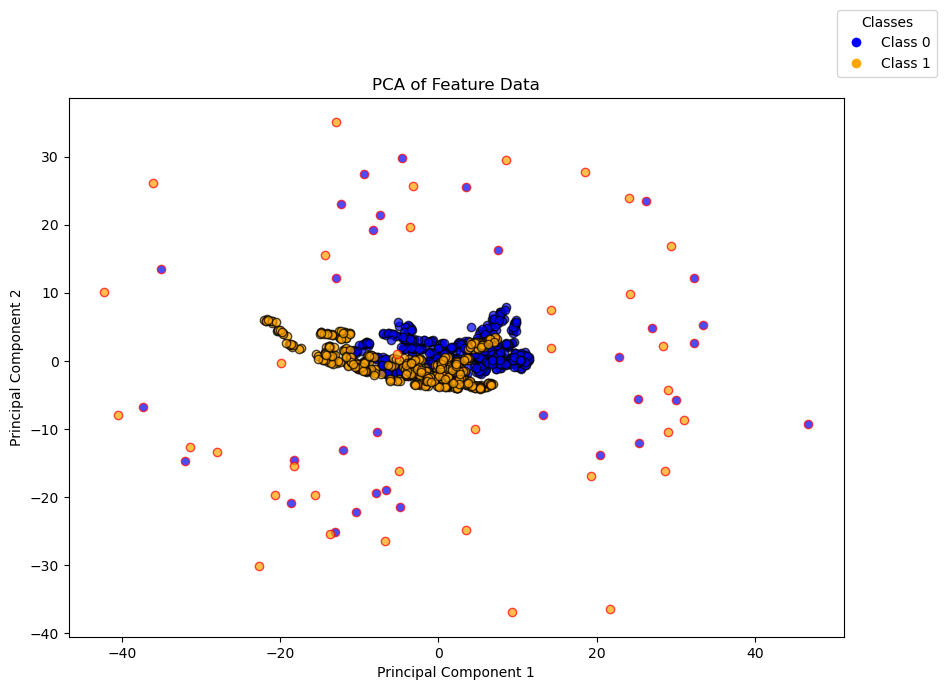

In [179]:
plot_pairwise_features(complete_df_with_outliers)
plot_2D_PCA(complete_df_with_outliers)
pass